# System Analysis

In [160]:
import pandas as pd
import numpy as np
import polars as pl
import seaborn as sns
import plotly as px
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import periodogram
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy import stats
import sranodec as anom

First we have to read data from our 3 pickle files.

In [2]:
cpu = pd.read_pickle('../../data/cpu.pkl')
mem = pd.read_pickle('../../data/memory.pkl')
net = pd.read_pickle('../../data/network.pkl')

# Now we change the dataframes to polars for faster processing
cpu = pl.from_pandas(cpu)
mem = pl.from_pandas(mem)
net = pl.from_pandas(net)

Now we have to change the `timestamp` column to datetime to utilize the python functionalities.

In [3]:
cpu = cpu.with_columns(pl.col('timestamp').apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ')))
net = net.with_columns(pl.col('timestamp').apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ')))
mem = mem.with_columns(pl.col('timestamp').apply(lambda x: dt.datetime.strptime(x, '%Y-%m-%dT%H:%M:%S.%fZ')))

In [4]:
cpu.__str__

<bound method DataFrame.__str__ of shape: (1_331_490, 8)
┌───────────┬────────────┬────────────┬────────────┬────────────┬───────────┬───────────┬──────────┐
│ cpu.cores ┆ cpu.idle.p ┆ cpu.user.p ┆ cpu.system ┆ cpu.steal. ┆ timestamp ┆ event     ┆ node     │
│ ---       ┆ ct         ┆ ct         ┆ .pct       ┆ pct        ┆ ---       ┆ ---       ┆ ---      │
│ i64       ┆ ---        ┆ ---        ┆ ---        ┆ ---        ┆ datetime[ ┆ str       ┆ str      │
│           ┆ f64        ┆ f64        ┆ f64        ┆ f64        ┆ μs]       ┆           ┆          │
╞═══════════╪════════════╪════════════╪════════════╪════════════╪═══════════╪═══════════╪══════════╡
│ 4         ┆ 3.8109     ┆ 0.0813     ┆ 0.1078     ┆ null       ┆ 2023-03-1 ┆ system.cp ┆ QASERVER │
│           ┆            ┆            ┆            ┆            ┆ 3 07:04:3 ┆ u         ┆          │
│           ┆            ┆            ┆            ┆            ┆ 1.079     ┆           ┆          │
│ 4         ┆ 3.7359     ┆ 0.1422 

# CPU

## Calculate standarized values

Now we want to calculate the standard values by dividing the percentage of cpu usage by the number of cores.

In [4]:
cpu2 = (
    cpu
    .lazy()
    .with_columns(
        (pl.col('cpu.idle.pct') / pl.col('cpu.cores')).alias('idle.pct'),
        (pl.col('cpu.system.pct') / pl.col('cpu.cores')).alias('system.pct'),
        (pl.col('cpu.user.pct') / pl.col('cpu.cores')).alias('user.pct'),
        (pl.col('cpu.steal.pct') / pl.col('cpu.cores')).alias('steal.pct'),
    )
    .collect()
)

The code below is a resampling implementation in polars, this will not be used for now as matplotlib is easier to use with pandas

In [28]:
# out1 = cpu2.upsample(time_column="timestamp", every="1m").fill_null(strategy="forward")

argument in operation 'upsample' is not explicitly sorted

- If your data is ALREADY sorted, set the sorted flag with: '.set_sorted()'.
- If your data is NOT sorted, sort the 'expr/series/column' first.

This might become an error in a future version.
    


We drop the original columns, as the standarized values help us more now.

In [5]:
out1 = cpu2.drop(columns=['cpu.idle.pct','cpu.user.pct','cpu.system.pct','cpu.steal.pct'])
# out1 = out1.drop(columns=['cpu.idle.pct','cpu.user.pct','cpu.system.pct','cpu.steal.pct'])

In [35]:
out1

timestamp,cpu.cores,event,node,idle.pct,system.pct,user.pct,steal.pct
datetime[μs],i64,str,str,f64,f64,f64,f64
2023-03-13 07:04:31.079,4,"""system.cpu""","""QASERVER""",0.952725,0.02695,0.020325,null
2023-03-13 07:05:31.079,4,"""system.cpu""","""QASERVER""",0.952725,0.02695,0.020325,null
2023-03-13 07:06:31.079,4,"""system.cpu""","""QASERVER""",0.952725,0.02695,0.020325,null
2023-03-13 07:07:31.079,4,"""system.cpu""","""QASERVER""",0.952725,0.02695,0.020325,null
2023-03-13 07:08:31.079,4,"""system.cpu""","""QASERVER""",0.952725,0.02695,0.020325,null
2023-03-13 07:09:31.079,4,"""system.cpu""","""QASERVER""",0.952725,0.02695,0.020325,null
2023-03-13 07:10:31.079,4,"""system.cpu""","""QASERVER""",0.952725,0.02695,0.020325,null
2023-03-13 07:11:31.079,4,"""system.cpu""","""QASERVER""",0.952725,0.02695,0.020325,null
2023-03-13 07:12:31.079,4,"""system.cpu""","""QASERVER""",0.952725,0.02695,0.020325,null


## Initial Plotting

First we change from polars dataframes to pandas dataframes as stated previously for a better implementations.

In [6]:
out1 = out1.to_pandas()

Now we resample to have our data every one minute and fill the null values with `first`. Which utilized the previous values.

In [7]:
df_ = out1.resample('1min', on="timestamp").agg("first").ffill()

In [8]:
df_

,cpu.cores,event,node,idle.pct,system.pct,user.pct,steal.pct
timestamp,,,,,,,
2023-03-01 00:00:00,4.0,system.cpu,QASERVER,0.984775,0.010150,0.005075,0.0
2023-03-01 00:01:00,4.0,system.cpu,QASERVER,0.979275,0.011350,0.009375,0.0
2023-03-01 00:02:00,4.0,system.cpu,QASERVER,0.965250,0.016800,0.017950,0.0
2023-03-01 00:03:00,4.0,system.cpu,QASERVER,0.983600,0.009375,0.007025,0.0
2023-03-01 00:04:00,4.0,system.cpu,QASERVER,0.955475,0.024600,0.019925,0.0
...,...,...,...,...,...,...,...
2023-03-31 23:56:00,16.0,system.cpu,PRUEBAS,0.998062,0.001125,0.000813,0.0
2023-03-31 23:57:00,16.0,system.cpu,PRUEBAS,0.997437,0.001250,0.001250,0.0
2023-03-31 23:58:00,16.0,system.cpu,PRUEBAS,0.997812,0.001125,0.001000,0.0


In [9]:
df_['idle.pct'] = df_['idle.pct']*100
df_['system.pct'] = df_['system.pct']*100
df_['user.pct'] = df_['user.pct']*100
df_['steal.pct'] = df_['steal.pct']*100

In [21]:
def plot_server_info(df: pd.DataFrame, servers: list):
    """
    This function plots the cpu usage of the servers in the list servers.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing the cpu usage of the servers.
    servers : list
        The list of servers to plot.

    Returns
    -------
    None.

    """

    for server in servers:
        fig, ax = plt.subplots(5,1, figsize=(20, 15))

        sum_all = df_[df_['node'] == server]["user.pct"]+df_[df_['node'] == server]["idle.pct"]+df_[df_['node'] == server]["system.pct"]+df_[df_['node'] == server]["steal.pct"]
        ax[0].plot(df_[df_['node'] == server]["idle.pct"])
        ax[0].set_title(f'{server} idle percentage')
        ax[1].plot(df_[df_['node'] == server]["user.pct"])
        ax[1].set_title(f'{server} user percentage')
        ax[2].plot(df_[df_['node'] == server]["system.pct"])
        ax[3].set_title(f'{server} system percentage')
        ax[3].plot(df_[df_['node'] == server]["steal.pct"])
        ax[3].set_title(f'{server} steal percentage')
        ax[4].plot(sum_all)
        ax[4].set_title(f'{server} total percentage')

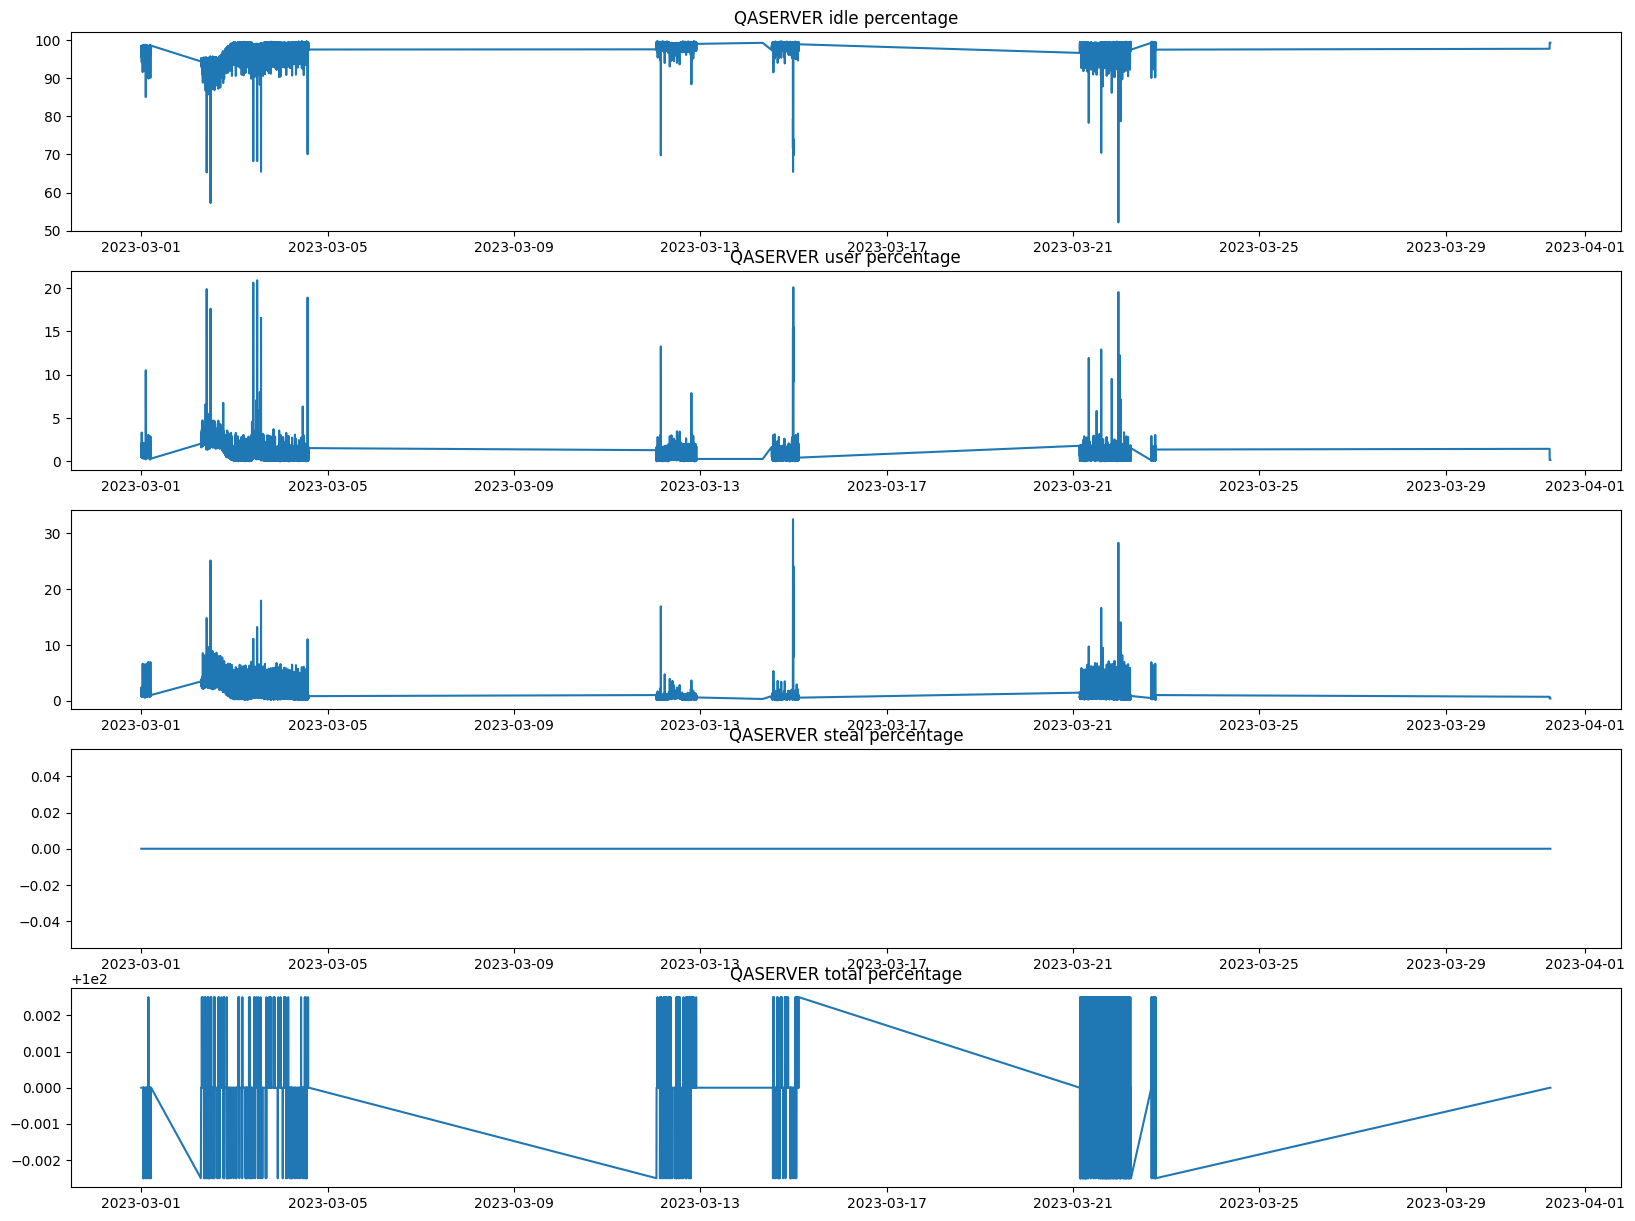

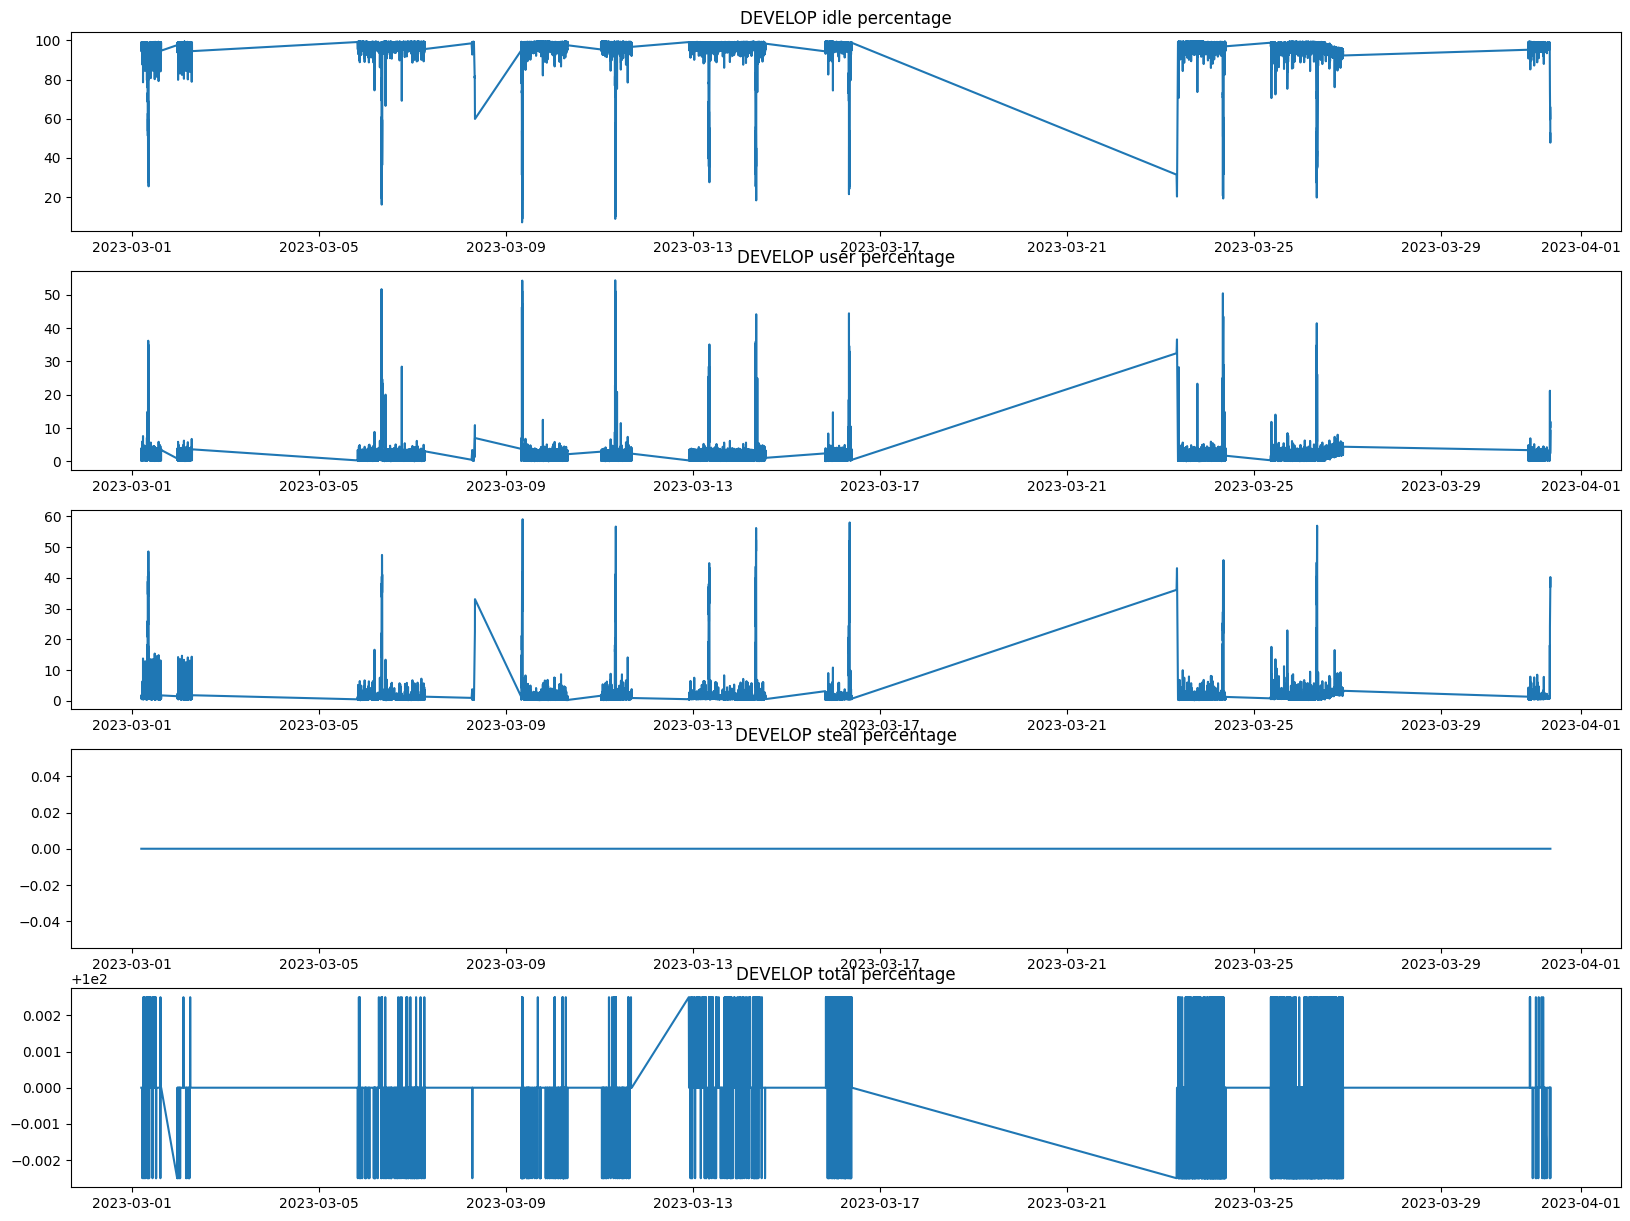

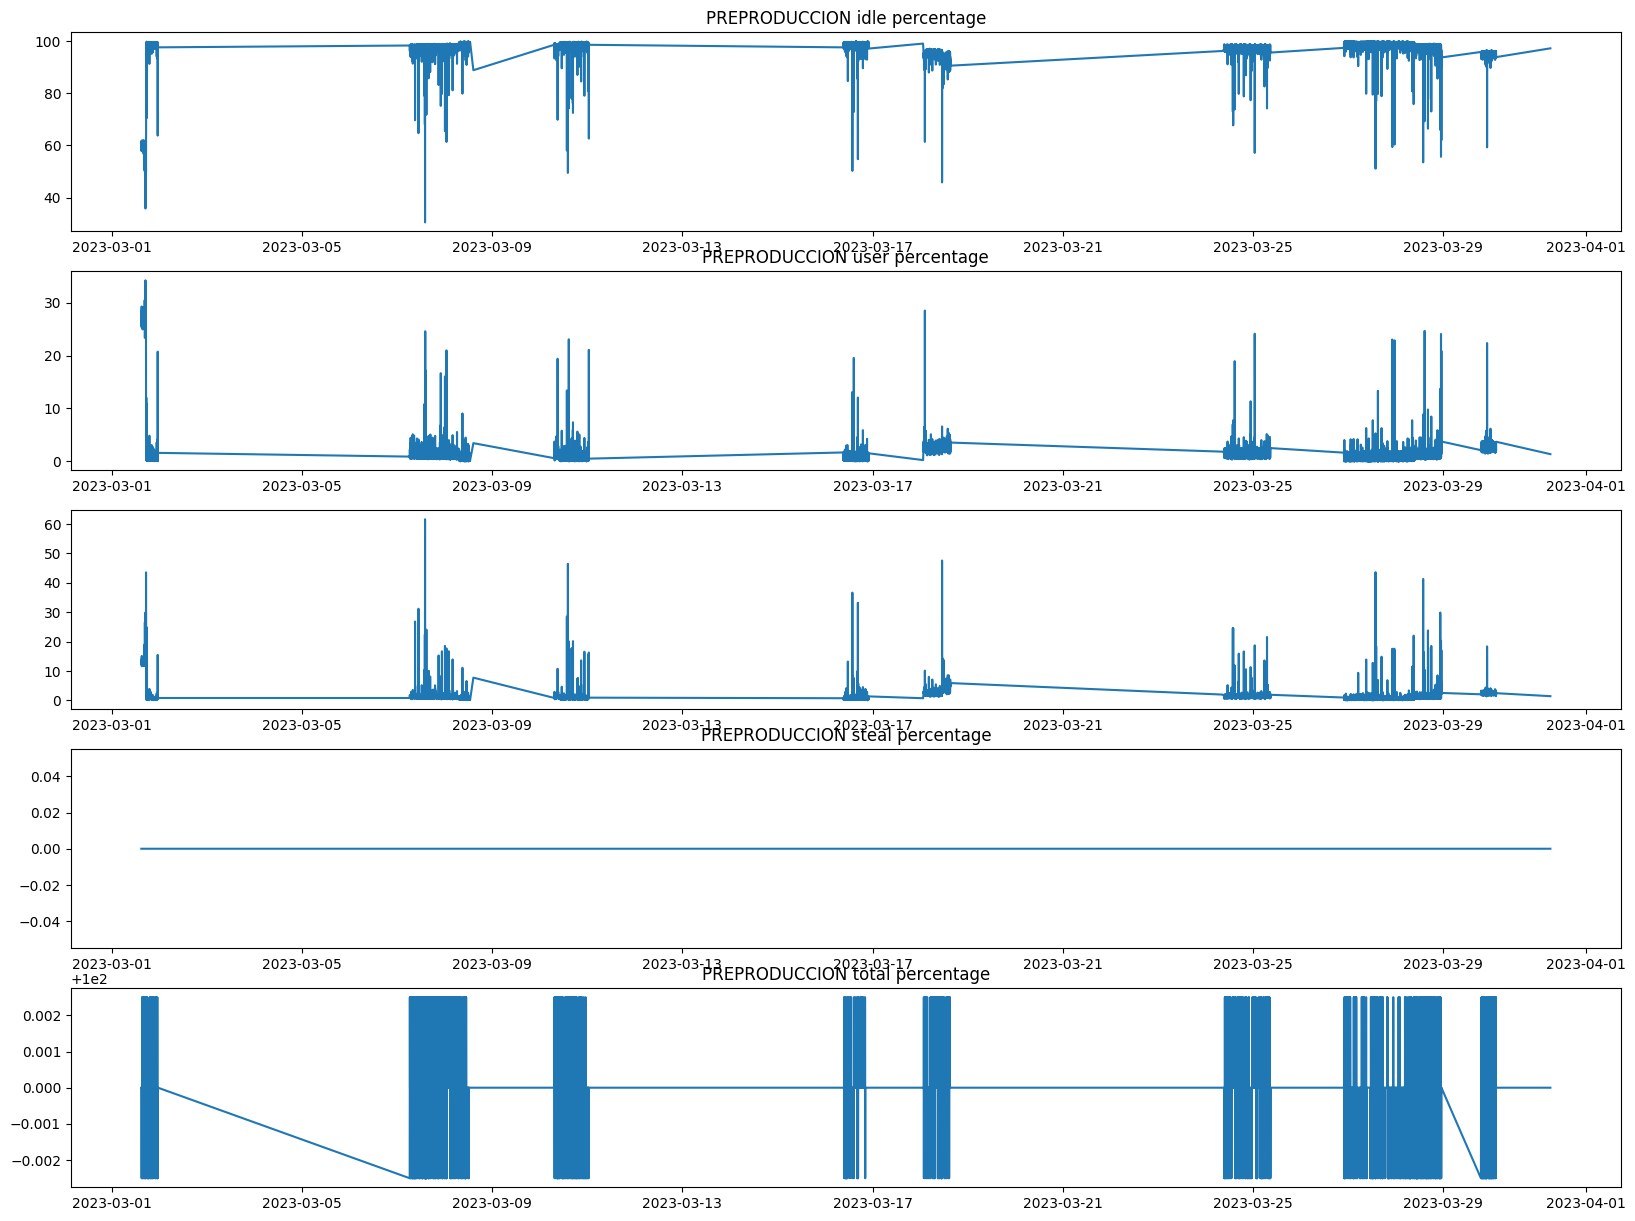

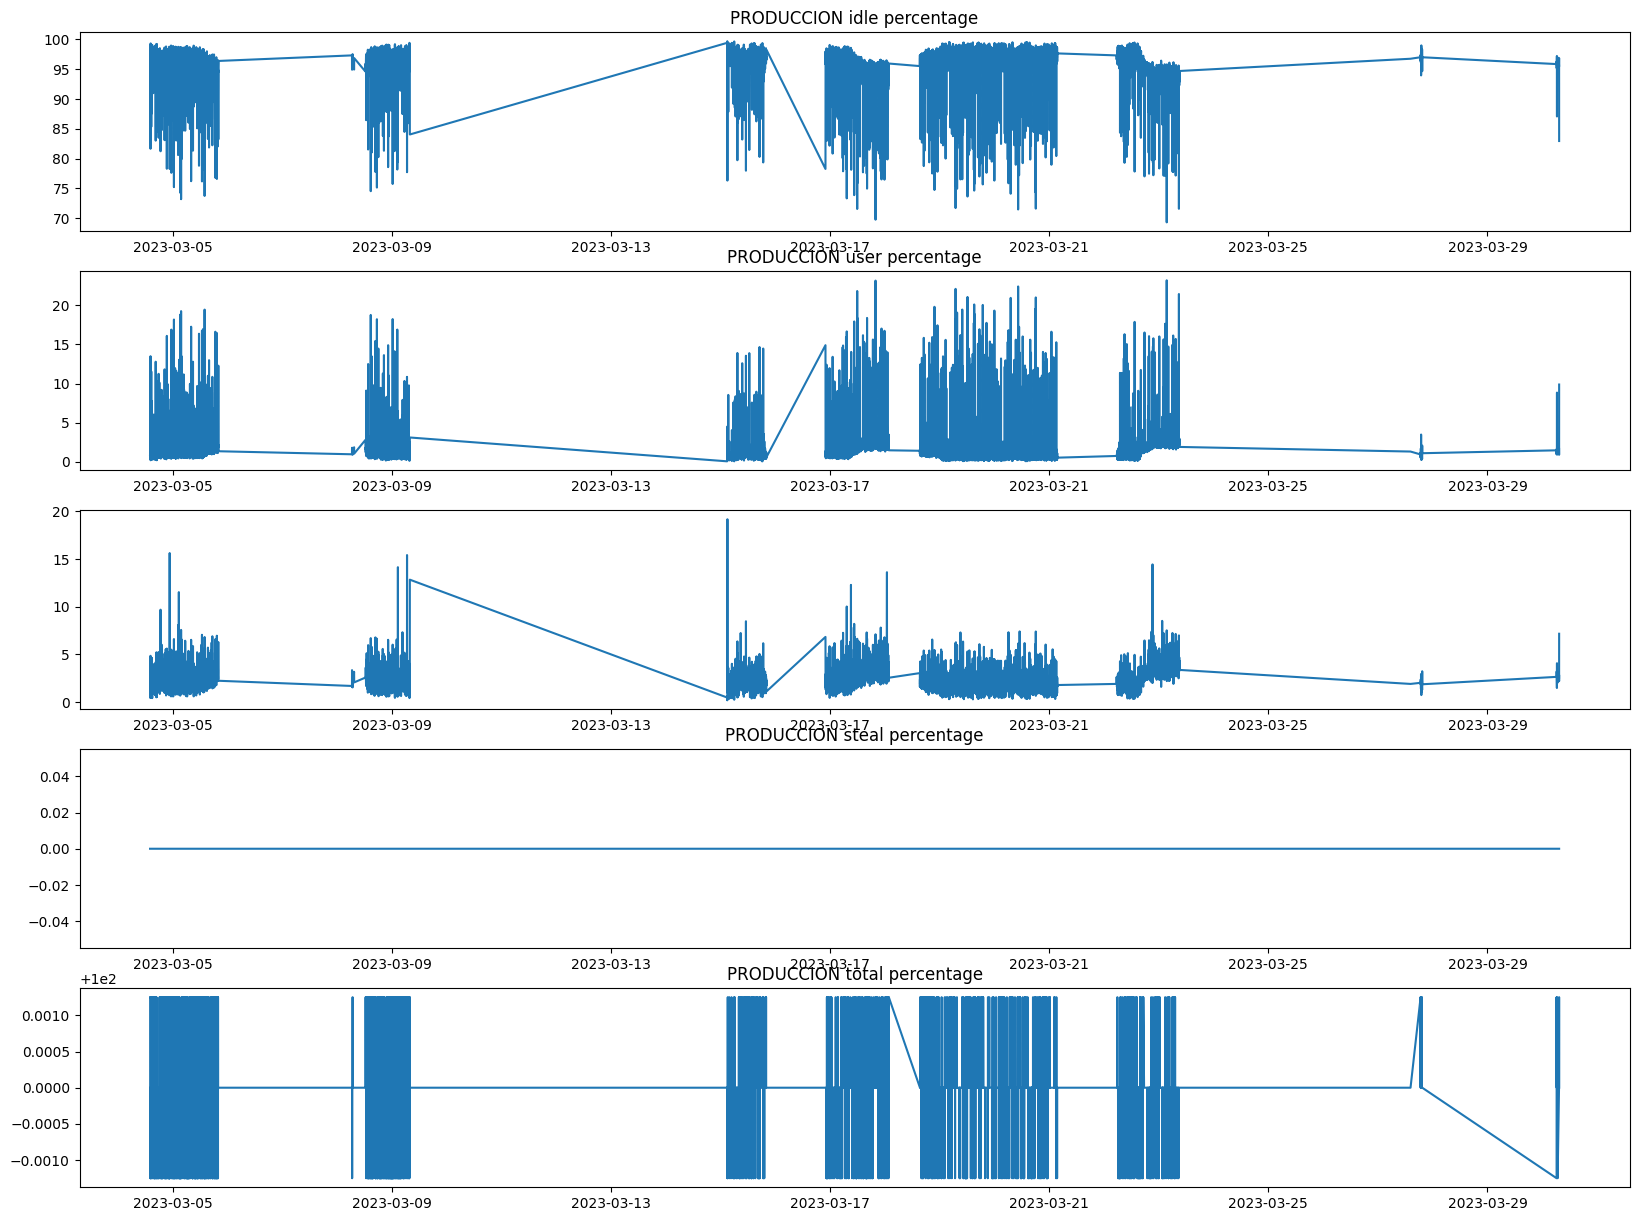

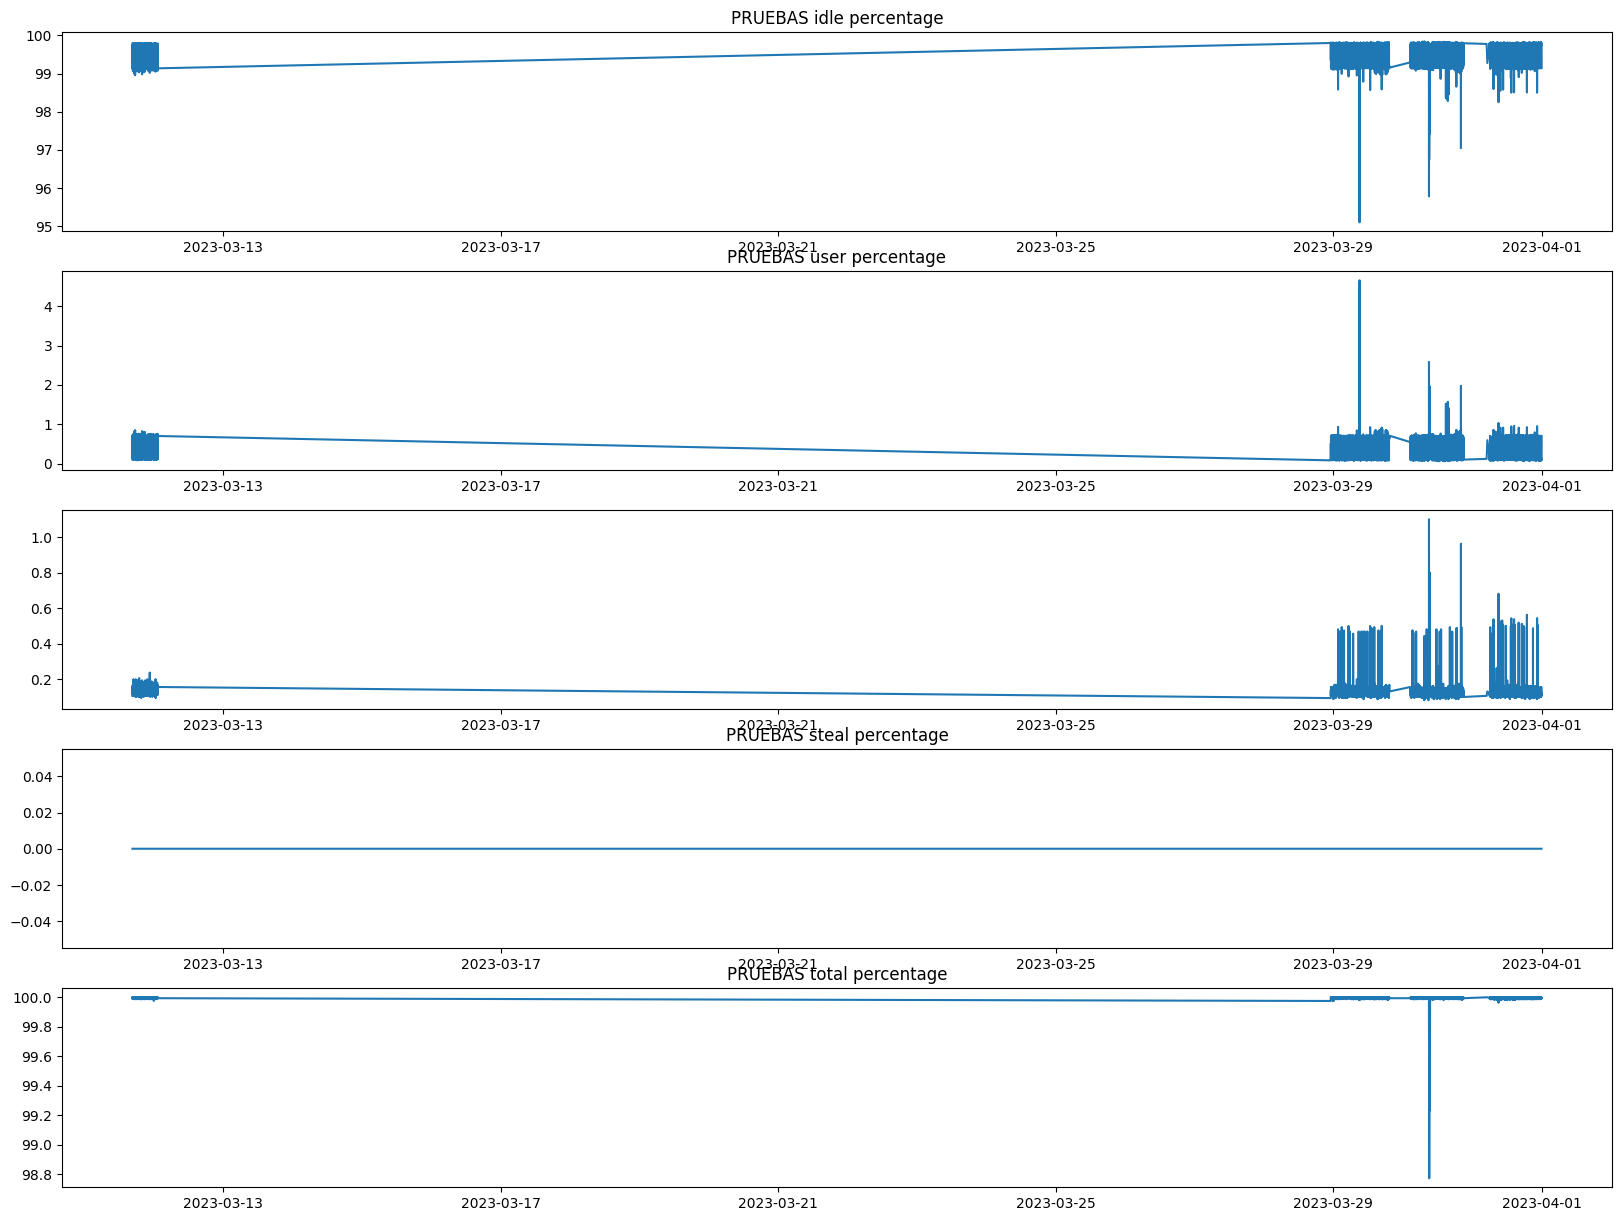

In [22]:
servers = df_['node'].unique()
plot_server_info(df_, servers)

# Network

net

In [40]:
net2 = (
    net
    .lazy()
    .with_columns(
        ((pl.col('network.out.bytes') / (pl.col('network.out.bytes')+pl.col('network.in.bytes'))*100).alias('out.pct')),
        ((pl.col('network.in.bytes') / (pl.col('network.out.bytes')+pl.col('network.in.bytes'))*100).alias('in.pct'))
    )
    .collect()
)

In [41]:
net2 = net2.drop(columns=['network.out.bytes', 'network.in.bytes'])

In [42]:
out2 = net2.to_pandas()

In [43]:
out2

,timestamp,event,node,out.pct,in.pct
0,2023-03-13 07:05:01.081,system.network,QASERVER,57.474349,42.525651
1,2023-03-13 07:05:01.081,system.network,QASERVER,NaN,NaN
2,2023-03-13 07:04:41.070,system.network,QASERVER,57.474445,42.525555
3,2023-03-13 07:04:41.070,system.network,QASERVER,NaN,NaN
4,2023-03-13 07:14:51.087,system.network,QASERVER,57.474822,42.525178
...,...,...,...,...,...
3993174,2023-03-08 06:24:09.991,system.network,PRUEBAS,50.000000,50.000000
3993175,2023-03-08 06:24:29.991,system.network,PRUEBAS,NaN,NaN
3993176,2023-03-08 06:24:29.991,system.network,PRUEBAS,73.160282,26.839718
3993177,2023-03-08 06:27:49.991,system.network,PRUEBAS,NaN,NaN


In [44]:
out2 = out2.resample('1min', on="timestamp").agg("first").ffill()

In [45]:
out2

,event,node,out.pct,in.pct
timestamp,,,,
2023-03-01 00:00:00,system.network,QASERVER,56.682279,43.317721
2023-03-01 00:01:00,system.network,QASERVER,56.682837,43.317163
2023-03-01 00:02:00,system.network,QASERVER,56.682870,43.317130
2023-03-01 00:03:00,system.network,QASERVER,56.682846,43.317154
2023-03-01 00:04:00,system.network,QASERVER,56.682789,43.317211
...,...,...,...,...
2023-03-31 23:56:00,system.network,PRUEBAS,72.220960,27.779040
2023-03-31 23:57:00,system.network,PRUEBAS,72.221260,27.778740
2023-03-31 23:58:00,system.network,PRUEBAS,50.000000,50.000000


In [46]:
def plot_network_info(df: pd.DataFrame, servers: list):
    """
    This function plots the cpu usage of the servers in the list servers.

    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing the cpu usage of the servers.
    servers : list
        The list of servers to plot.

    Returns
    -------
    None.

    """

    for server in servers:
        fig, ax = plt.subplots(3,1, figsize=(20, 8))

        sum_all = df[df['node'] == server]["out.pct"]+df[df['node'] == server]["in.pct"]
        ax[0].plot(df[df['node'] == server]["in.pct"])
        ax[0].set_title(f'{server} in percentage')
        ax[1].plot(df[df['node'] == server]["out.pct"])
        ax[1].set_title(f'{server} out percentage')
        ax[2].plot(sum_all)
        ax[2].set_title(f'{server} total percentage')

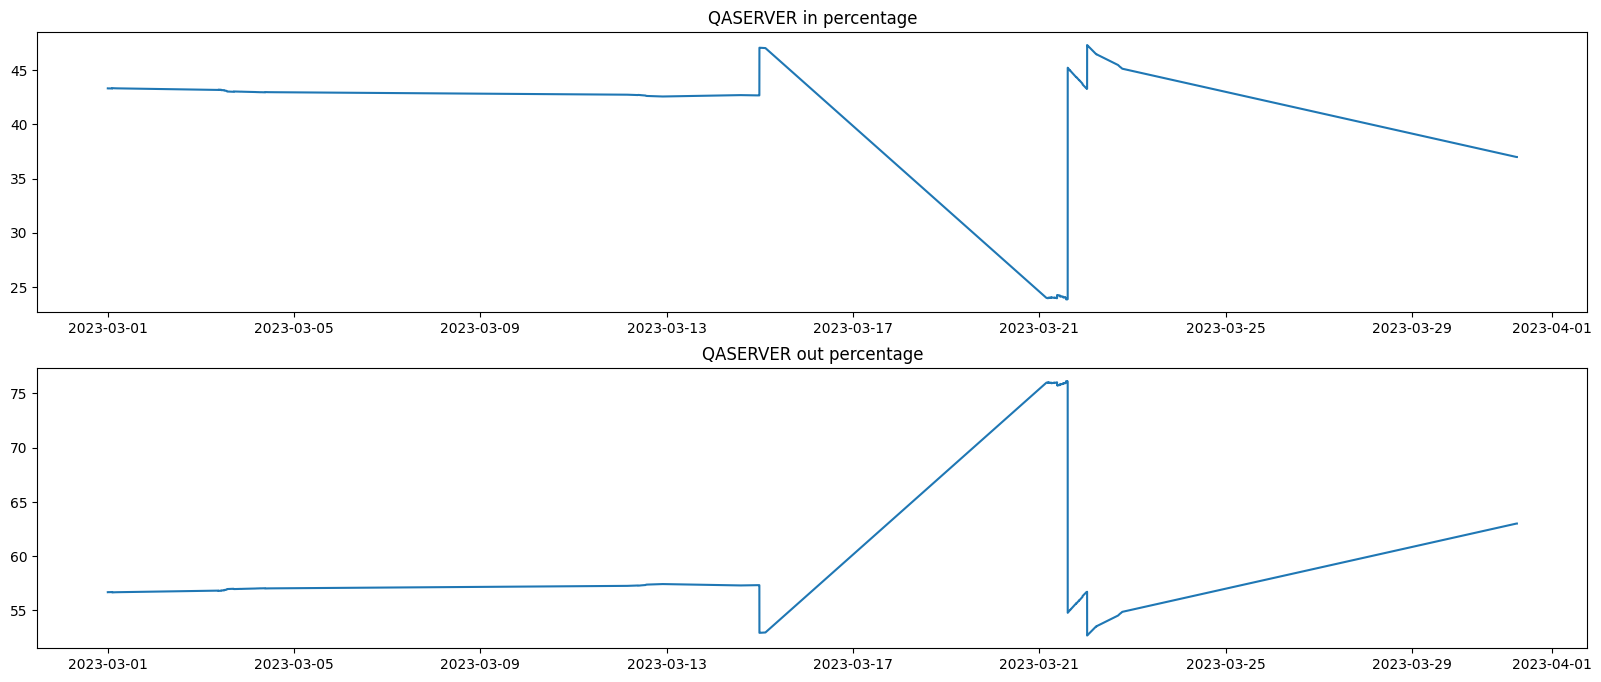

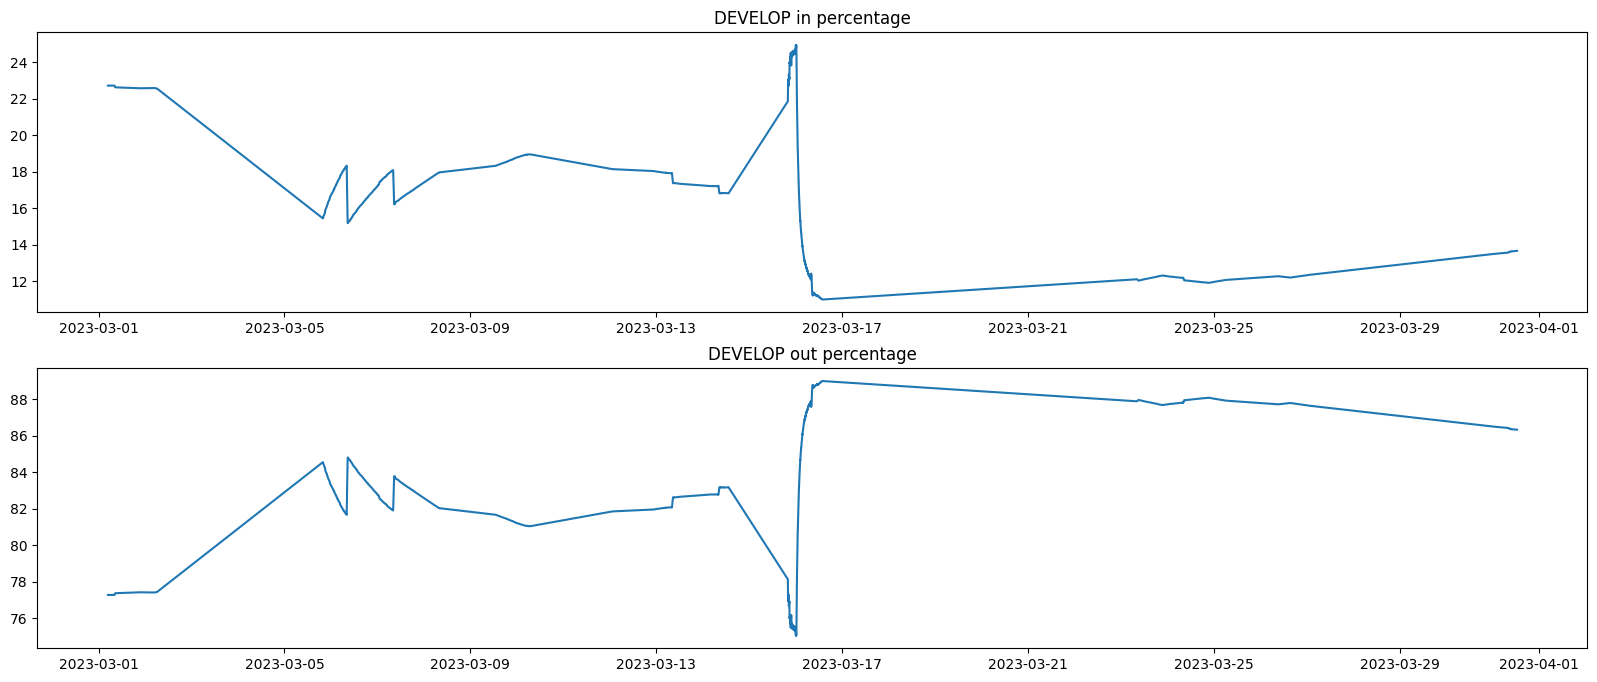

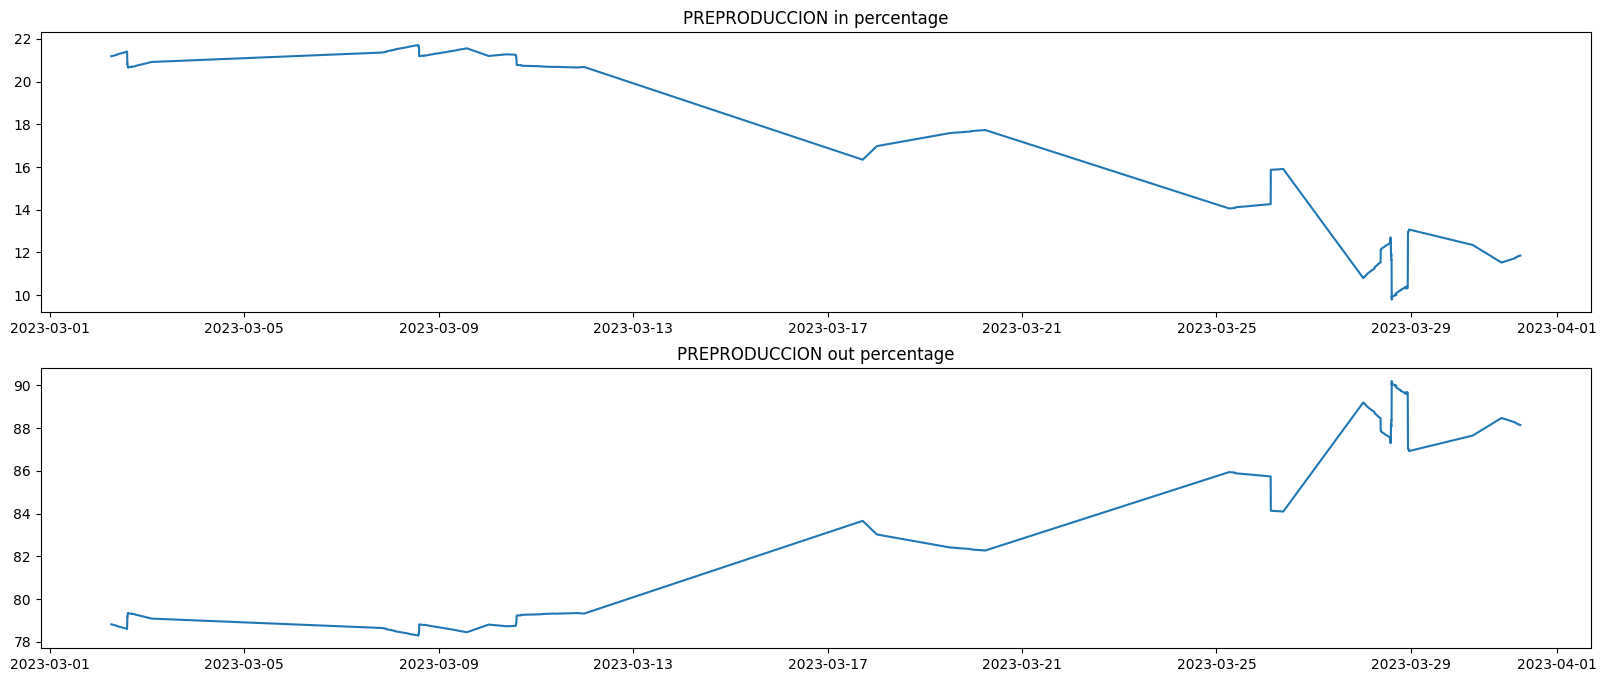

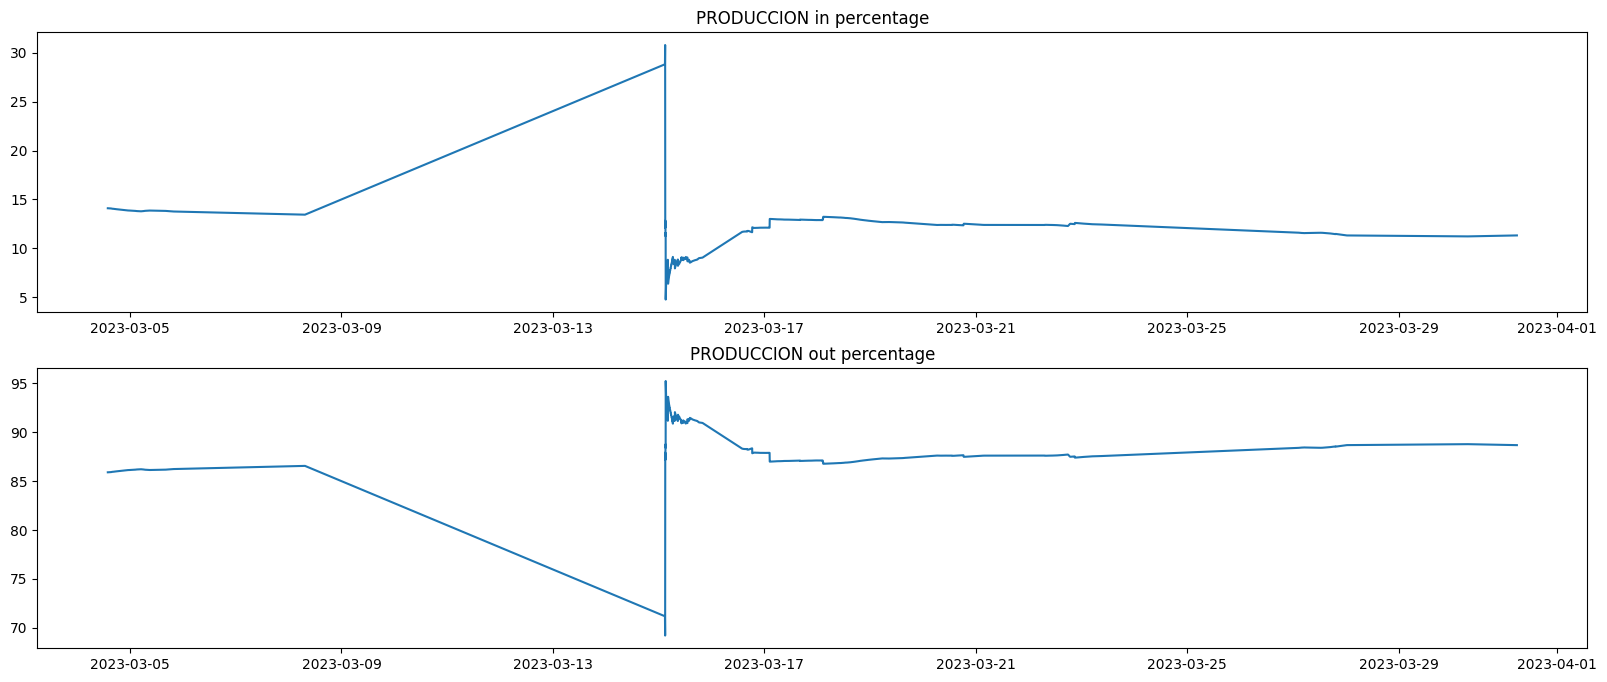

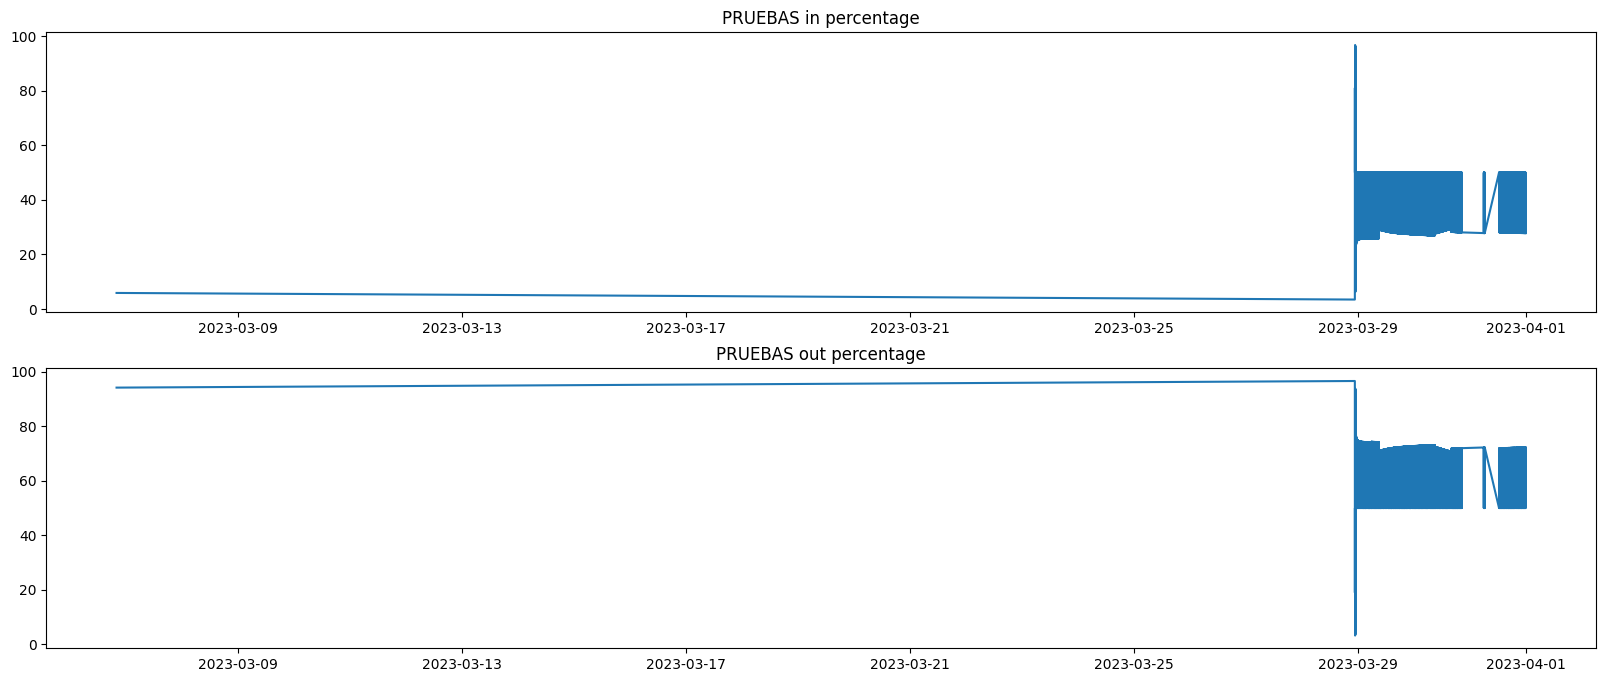

In [47]:
plot_network_info(out2, servers)

In [8]:
network = net2.to_pandas()

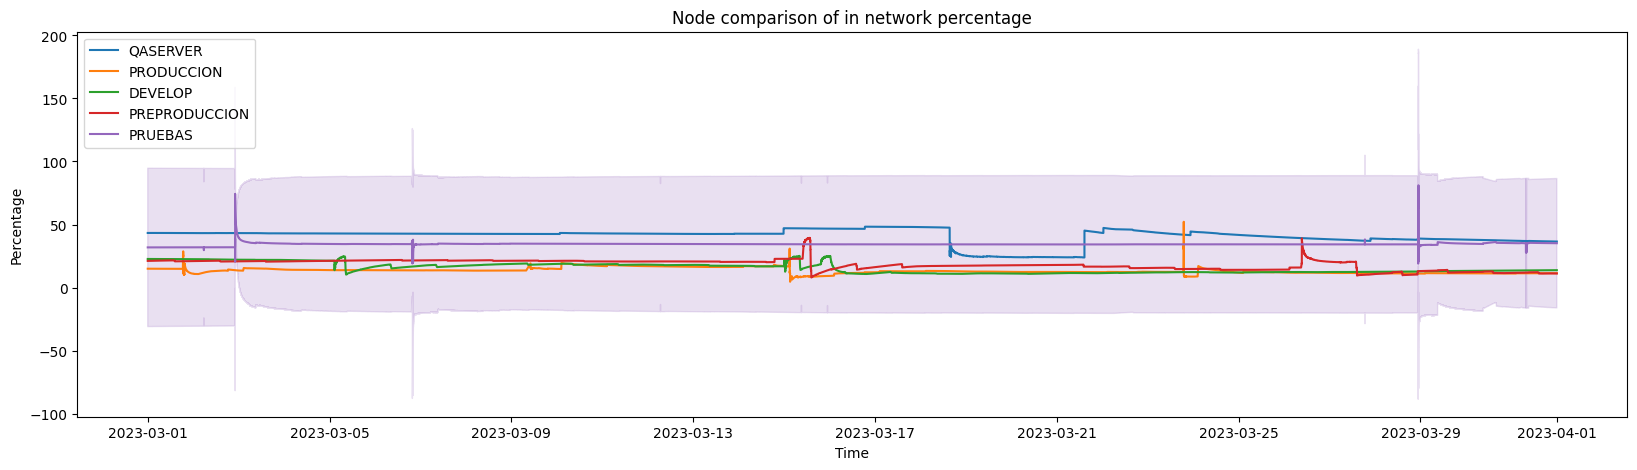

In [66]:
plt.figure(figsize=(20,5))

sns.lineplot(data=network, x="timestamp", y="in.pct", hue = 'node', errorbar=("sd", 4))
plt.title('Node comparison of in network percentage')
plt.xlabel('Time')
plt.ylabel('Percentage')
plt.legend(loc='upper left')
plt.show()

In [158]:
# less than period
amp_window_size=24
# (maybe) as same as period
series_window_size=24
# a number enough larger than period
score_window_size=100

df = out2

In [164]:
df.columns

Index(['event', 'node', 'out.pct', 'in.pct', 'in_roll_pct'], dtype='object')

/opt/homebrew/lib/python3.10/site-packages/sranodec/util.py:31: RuntimeWarning: invalid value encountered in double_scalars
  slope = [(last_value - v) / i for (i, v) in enumerate(values[::-1])]


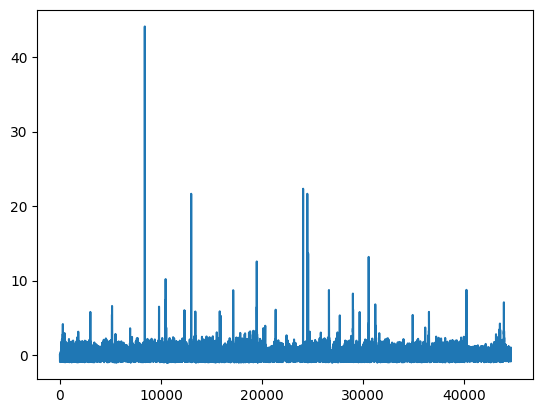

In [167]:
spec = anom.Silency(amp_window_size, series_window_size, score_window_size)

# test_signal = df[(df.index > '2023-03-04 12:00:00') & (df.index < '2023-03-04 18:00:00')]['out.pct']
test_signal = df['out.pct']

score = spec.generate_anomaly_score(test_signal)
plt.plot(score)

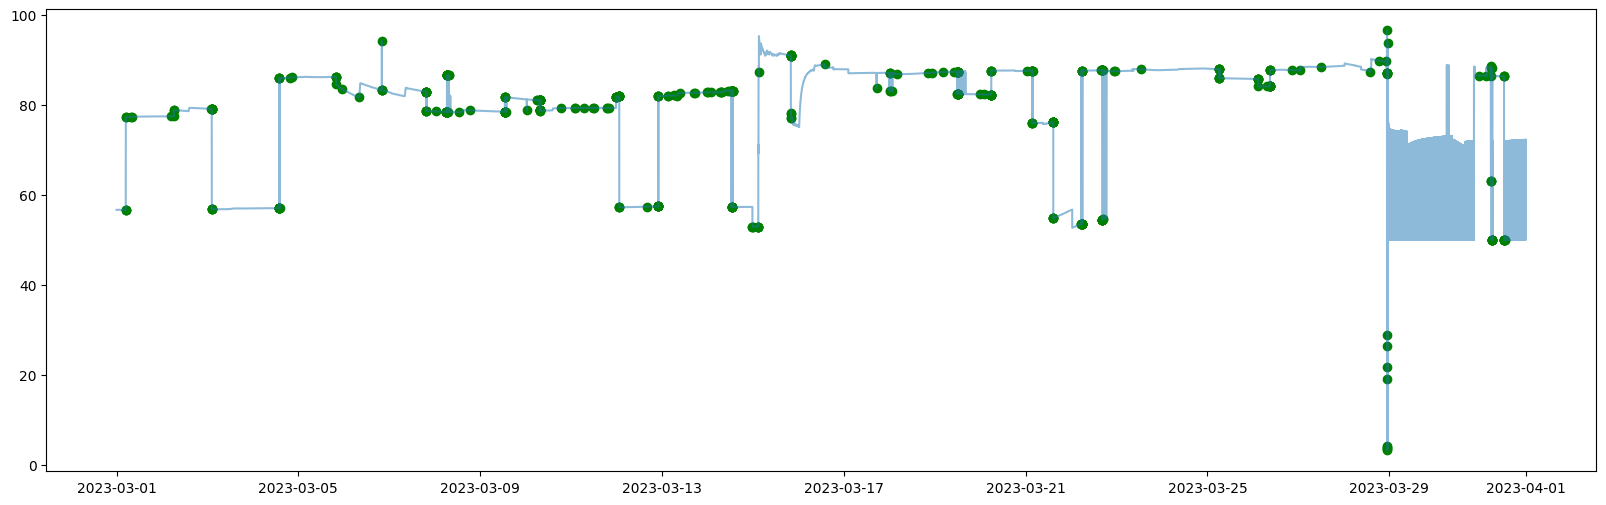

In [168]:
plt.figure(figsize=(20, 6))
plt.plot(test_signal, alpha=0.5, label="observation")
index_changes = np.where(score > np.percentile(score, 99))[0]
# plt.scatter(test_signal.iloc[index_changes], test_signal.iloc[index_changes], c='r')
plt.scatter(test_signal.iloc[index_changes].index, y = test_signal.iloc[index_changes], c='green', label="change point")